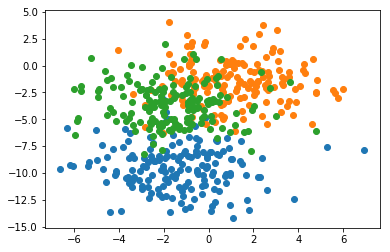

In [2]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from numpy import where

X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)

for class_value in range(3):
	row_ix = where(y == class_value)
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
pyplot.show()

Train: 0.840, Test: 0.818


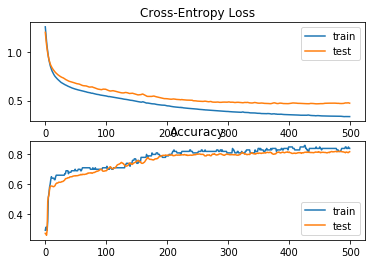

In [2]:
from sklearn.datasets import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

y = to_categorical(y)

n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)

_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

pyplot.subplot(211)
pyplot.title('Cross-Entropy Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy learning curves
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

> 1: single=0.810, ensemble=0.810
> 2: single=0.810, ensemble=0.810
> 3: single=0.806, ensemble=0.812
> 4: single=0.812, ensemble=0.814
> 5: single=0.807, ensemble=0.815
> 6: single=0.810, ensemble=0.815
> 7: single=0.816, ensemble=0.816
> 8: single=0.805, ensemble=0.816
> 9: single=0.815, ensemble=0.815
> 10: single=0.813, ensemble=0.812
Accuracy 0.810 (0.003)


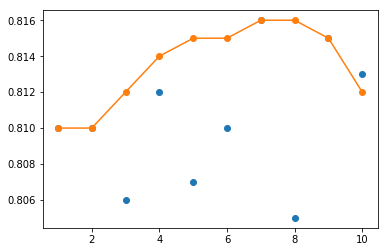

In [3]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
import numpy
from numpy import array
from numpy import argmax


def fit_model(trainX, trainy):
	trainy_enc = to_categorical(trainy)
	model = Sequential()
	model.add(Dense(25, input_dim=2, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	model.fit(trainX, trainy_enc, epochs=500, verbose=0)
	return model

def ensemble_predictions(members, testX):
	yhats = [model.predict(testX) for model in members]
	yhats = array(yhats)
	summed = numpy.sum(yhats, axis=0)
	result = argmax(summed, axis=1)
	return result

def evaluate_n_members(members, n_members, testX, testy):
	subset = members[:n_members]
	yhat = ensemble_predictions(subset, testX)
	return accuracy_score(testy, yhat)

X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

n_members = 10
members = [fit_model(trainX, trainy) for _ in range(n_members)]

single_scores, ensemble_scores = list(), list()
for i in range(1, len(members)+1):
	ensemble_score = evaluate_n_members(members, i, testX, testy)
	testy_enc = to_categorical(testy)
	_, single_score = members[i-1].evaluate(testX, testy_enc, verbose=0)
	print('> %d: single=%.3f, ensemble=%.3f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)

print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))

x_axis = [i for i in range(1, len(members)+1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

In [5]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from numpy import array
from numpy import argmax
from numpy import tensordot
from numpy.linalg import norm
from itertools import product


def fit_model(trainX, trainy):
	trainy_enc = to_categorical(trainy)
	# define model
	model = Sequential()
	model.add(Dense(25, input_dim=2, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy_enc, epochs=500, verbose=0)
	return model


def ensemble_predictions(members, weights, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = array(yhats)
	# weighted sum across ensemble members
	summed = tensordot(yhats, weights, axes=((0),(0)))
	# argmax across classes
	result = argmax(summed, axis=1)
	return result


def evaluate_ensemble(members, weights, testX, testy):
	# make prediction
	yhat = ensemble_predictions(members, weights, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)


def normalize(weights):
	# calculate l1 vector norm
	result = norm(weights, 1)
	# check for a vector of all zeros
	if result == 0.0:
		return weights
	# return normalized vector (unit norm)
	return weights / result


def grid_search(members, testX, testy):
	# define weights to consider
	w = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	best_score, best_weights = 0.0, None
	# iterate all possible combinations (cartesian product)
	for weights in product(w, repeat=len(members)):
		# skip if all weights are equal
		if len(set(weights)) == 1:
			continue
		# hack, normalize weight vector
		weights = normalize(weights)
		# evaluate weights
		score = evaluate_ensemble(members, weights, testX, testy)
		if score > best_score:
			best_score, best_weights = score, weights
			print('>%s %.3f' % (best_weights, best_score))
	return list(best_weights)


X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

n_members = 5
members = [fit_model(trainX, trainy) for _ in range(n_members)]

testy_enc = to_categorical(testy)
for i in range(n_members):
	_, test_acc = members[i].evaluate(testX, testy_enc, verbose=0)
	print('Model %d: %.3f' % (i+1, test_acc))

weights = [1.0/n_members for _ in range(n_members)]
score = evaluate_ensemble(members, weights, testX, testy)
print('Equal Weights Score: %.3f' % score)

weights = grid_search(members, testX, testy)
score = evaluate_ensemble(members, weights, testX, testy)
print('Grid Search Weights: %s, Score: %.3f' % (weights, score))

Model 1: 0.814
Model 2: 0.813
Model 3: 0.817
Model 4: 0.811
Model 5: 0.805
Equal Weights Score: 0.814
>[0. 0. 0. 0. 1.] 0.805
>[0. 0. 0. 1. 0.] 0.811
>[0. 0. 1. 0. 0.] 0.817
>[0.  0.5 0.5 0.  0. ] 0.818
>[0.         0.33333333 0.66666667 0.         0.        ] 0.819
>[0.         0.42857143 0.5        0.07142857 0.        ] 0.820
>[0.09090909 0.27272727 0.63636364 0.         0.        ] 0.821
Grid Search Weights: [0.09090909090909091, 0.2727272727272727, 0.6363636363636362, 0.0, 0.0], Score: 0.821


In [7]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from numpy import array
from numpy import argmax
from numpy import tensordot
from numpy.linalg import norm
from scipy.optimize import differential_evolution


def fit_model(trainX, trainy):
	trainy_enc = to_categorical(trainy)
	model = Sequential()
	model.add(Dense(25, input_dim=2, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	model.fit(trainX, trainy_enc, epochs=500, verbose=0)
	return model


def ensemble_predictions(members, weights, testX):
	yhats = [model.predict(testX) for model in members]
	yhats = array(yhats)
	summed = tensordot(yhats, weights, axes=((0),(0)))
	result = argmax(summed, axis=1)
	return result


def evaluate_ensemble(members, weights, testX, testy):
	yhat = ensemble_predictions(members, weights, testX)
	return accuracy_score(testy, yhat)


def normalize(weights):
	result = norm(weights, 1)
	if result == 0.0:
		return weights
	return weights / result

def loss_function(weights, members, testX, testy):
	normalized = normalize(weights)
	return 1.0 - evaluate_ensemble(members, normalized, testX, testy)


X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)

n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

n_members = 5
members = [fit_model(trainX, trainy) for _ in range(n_members)]

testy_enc = to_categorical(testy)
for i in range(n_members):
	_, test_acc = members[i].evaluate(testX, testy_enc, verbose=0)
	print('Model %d: %.3f' % (i+1, test_acc))

weights = [1.0/n_members for _ in range(n_members)]
score = evaluate_ensemble(members, weights, testX, testy)
print('Equal Weights Score: %.3f' % score)

bound_w = [(0.0, 1.0)  for _ in range(n_members)]

search_arg = (members, testX, testy)

result = differential_evolution(loss_function, bound_w, search_arg, maxiter=1000, tol=1e-7)

weights = normalize(result['x'])
print('Optimized Weights: %s' % weights)

score = evaluate_ensemble(members, weights, testX, testy)
print('Optimized Weights Score: %.3f' % score)

Model 1: 0.820
Model 2: 0.809
Model 3: 0.807
Model 4: 0.813
Model 5: 0.825
Equal Weights Score: 0.815
Optimized Weights: [0.36970075 0.00202045 0.0023739  0.01276953 0.61313537]
Optimized Weights Score: 0.827
